# Dataset Loading and Environment Setup

In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
!gdown 18d8LMm61ddRcHLvbncBJjxkA4LijFT-k
!gdown 1dY2Rvck-rsmyuqrciHLsteRurfptK9De
!gdown 1DI9mDSCfOZUc6FIwSdIo7KQPXmz3tYAb

Downloading...
From: https://drive.google.com/uc?id=18d8LMm61ddRcHLvbncBJjxkA4LijFT-k
To: /content/train.csv
100% 6.25M/6.25M [00:00<00:00, 90.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dY2Rvck-rsmyuqrciHLsteRurfptK9De
To: /content/dev.csv
100% 816k/816k [00:00<00:00, 153MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DI9mDSCfOZUc6FIwSdIo7KQPXmz3tYAb
To: /content/test.csv
100% 777k/777k [00:00<00:00, 148MB/s]


In [ ]:
%%capture
!pip install datasets
!pip install transformers
!pip install --upgrade accelerate
!pip install evaluate
!pip install datsets transformers[sentencepiece]
!pip install sentencepiece
!pip install rouge-score
!pip install bert_score
!python -m spacy download en_core_web_lg
!pip install optuna

In [ ]:
import torch
from torch import nn
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, TrainingArguments, Trainer, AutoTokenizer, AutoModel, T5Tokenizer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from rouge_score import rouge_scorer
from datasets import load_metric
import evaluate
from evaluate import load
import optuna


import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm

import tensorflow_hub as hub
from tensorflow import keras
import tensorflow as tf
from IPython.display import Image
import matplotlib.pyplot as plt


nlp = spacy.load('en_core_web_lg')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_id = 0 if str(device) == 'cuda' else -1

In [ ]:
train_df = pd.read_csv('train.csv')
dev_df = pd.read_csv('dev.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.head()

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,0,1.0,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR5G,Amazon Customer,Waaaay too BIG,One Star,1520812800
1,1,5.0,True,"05 16, 2018",ASECGGNQIT2RN,B0092UF54A,Debra DeGrand,Love these shoes!,Very confortable!,1526428800
2,2,3.0,False,"07 1, 2017",AE6W48FPMKO4L,B001IKJOLW,PineTree,Good indoor training shoes for running on trea...,Good indoor training shoes,1498867200
3,3,4.0,True,"12 25, 2009",A2VR6SWVSF6K4,B0017LD0BM,C. Schmitt,It is so handy to have this many reading glass...,Good Value,1261699200
4,4,4.0,True,"02 6, 2017",ADUWEIS0CHJV8,B001IKJOLW,Julie W.,"Nikes usually run small and I'm a 7.5, so I or...",I love them but they are definitely bright ora...,1486339200


# Extractive SentenceBERT

## 1. Creating a Custom Dataset

In [ ]:
def get_dicts(df, folder="test"):
  sents_dict = {}
  doc_dict = { i: {"article": df.reviewText[i], "highlight": df.summary[i]} for i in df.index }
  raw_docs = [ doc_dict[k]["article"] for k in doc_dict.keys()]

  doc_sents = {}
  sents_list = []
  raw_sents = []
  i = 0
  min_sent_length = 0
  for k in tqdm(doc_dict.keys()):
    article = doc_dict[k]["article"]
    highlight = doc_dict[k]["highlight"]
    sents = nlp(article).sents
    doc_sent_ids = []
    for sent in sents:
      if (len(sent)) > min_sent_length:
        sents_dict[i] = {"docid":k, "text": str(sent)}
        sents_list.append({"sentid":i, "docid":k, "text": str(sent) })
        raw_sents.append(str(sent))
        i += 1

  return doc_dict, sents_list

test_doc_dict, test_sents_list = get_dicts(test_df)
dev_doc_dict, dev_sents_list = get_dicts(dev_df)
train_doc_dict, train_sents_list = get_dicts(train_df)

  0%|          | 0/1388 [00:00<?, ?it/s]

  0%|          | 0/1387 [00:00<?, ?it/s]

  0%|          | 0/11095 [00:00<?, ?it/s]

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def get_rougue_score(text, highlights, metric="rougeL"):
  max_score = 0
  for h_text in highlights:
    score =  scorer.score(text, h_text)[metric].fmeasure
    # print(score, text, "\n \t" , h_text)
    if score > max_score:
      max_score = score
  return max_score


def get_label(sent, doc_dict,  score_threshold = 0.55):
  sent_id, doc_id, sentence = sent["sentid"], sent["docid"], sent["text"]
  highlights = doc_dict[doc_id]["highlight"].split("\n")
  doc = doc_dict[doc_id]["article"]

  label_score = get_rougue_score(sentence, highlights)
  # Normalize label to 0/1 based on rogue score threshold
  label_score = 0 if label_score < score_threshold else 1
  return (sentence, doc, label_score)

def sub_sample(sents_batch, doc_dict, neg_multiplier=2):
  # get labels
  vals = [get_label(x, doc_dict)  for x in sents_batch]

  # construct arrays of sentences, corresponding documents and labels
  sents, docs, y = [], [], []
  for row in vals:
    sents.append(row[0])
    docs.append(row[1])
    y.append(row[2])


  # get balanced number of positive and negative
  sub_df = pd.DataFrame.from_dict({"sents":sents, "docs":docs, "y":y})
  pos_df = sub_df[sub_df.y == 1]
  neg_df = sub_df[sub_df.y == 0]

  print("Negative sample size:", len(neg_df))
  print("Positive sample size:", len(pos_df))

  sub_neg_df = neg_df.sample(len(pos_df)*neg_multiplier, replace=True)
  balanced_df = pos_df.append(sub_neg_df)

  return balanced_df

In [ ]:
train_bdf = sub_sample(train_sents_list, train_doc_dict)
test_bdf = sub_sample(test_sents_list, test_doc_dict)

Negative sample size: 58795
Positive sample size: 2154


<ipython-input-8-1924692670c4>:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = pos_df.append(sub_neg_df)


Negative sample size: 7311
Positive sample size: 269


<ipython-input-8-1924692670c4>:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = pos_df.append(sub_neg_df)


In [ ]:
sentence_model_name = "sentence-transformers/paraphrase-MiniLM-L3-v2"
stage1_tokenizer = AutoTokenizer.from_pretrained(sentence_model_name)

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 1e-05

In [ ]:
# Create a Data Loader Class
class AmazonReviewData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        sentence = str(self.data.iloc[index].sents)
        sentence = " ".join(sentence.split())

        document = str(self.data.iloc[index].docs)
        document = " ".join(document.split())

        inputs = self.tokenizer.batch_encode_plus(
            [sentence, document],
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'sent_ids': torch.tensor(ids[0], dtype=torch.long),
            'doc_ids': torch.tensor(ids[1], dtype=torch.long),
            'sent_mask': torch.tensor(mask[0], dtype=torch.long),
            'doc_mask': torch.tensor(mask[1], dtype=torch.long),
            'targets': torch.tensor([self.data.iloc[index].y], dtype=torch.long)
        }

    def __len__(self):
        return self.len



training_set = AmazonReviewData(train_bdf,  stage1_tokenizer, MAX_LEN)
testing_set = AmazonReviewData(test_bdf,  stage1_tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## 2. Model Training

In [ ]:
# get mean pooling for sentence bert models
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.
# Note that different sentence transformer models may have different in_feature sizes
class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2", in_features=384):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(in_features*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask)
        sentence_embeddings = mean_pooling(sent_output, sent_mask)

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask)
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings

        # Concatenate input features and their elementwise product
        concat_features = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)

        pooler = self.pre_classifier(concat_features)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output)

        return output


In [ ]:
extraction_model = SentenceBertClass(model_name=sentence_model_name)
extraction_model.to(device)
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params =  extraction_model.parameters(), lr=LEARNING_RATE)

pytorch_model.bin:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
def train_extraction_model(
    model,
    training_loader,
    num_epochs = 5,
    print_n_steps = 1000
    ):
  acc_step_holder, loss_step_holder = [], []

  print("Training Extraction Model")
  for epoch in range(num_epochs):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        sent_ids = data['sent_ids'].to(device, dtype = torch.long)
        doc_ids = data['doc_ids'].to(device, dtype = torch.long)
        sent_mask = data['sent_mask'].to(device, dtype = torch.long)
        doc_mask = data['doc_mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(sent_ids, doc_ids, sent_mask, doc_mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%print_n_steps==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(str(_* train_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)
            acc_step_holder.append(accu_step), loss_step_holder.append(loss_step)
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

  return acc_step_holder, loss_step_holder

In [ ]:
torch.cuda.empty_cache()
train_extraction_model(
    extraction_model,
    training_loader,
    num_epochs= 30
)

Training Extraction Model


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 51.5625 Loss -> 0.6940794587135315
The Total Accuracy for Epoch 0: 65.62983596409781
Training Loss Epoch: 0.6214581515529368
Training Accuracy Epoch: 65.62983596409781


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 70.3125 Loss -> 0.5148146152496338
The Total Accuracy for Epoch 1: 77.77777777777777
Training Loss Epoch: 0.4632339158860764
Training Accuracy Epoch: 77.77777777777777


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 71.875 Loss -> 0.5219038724899292
The Total Accuracy for Epoch 2: 79.69668833178582
Training Loss Epoch: 0.4328240241744731
Training Accuracy Epoch: 79.69668833178582


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 71.875 Loss -> 0.5368925333023071
The Total Accuracy for Epoch 3: 80.37759207675643
Training Loss Epoch: 0.4171463136035617
Training Accuracy Epoch: 80.37759207675643


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 85.9375 Loss -> 0.34509286284446716
The Total Accuracy for Epoch 4: 81.35252243887341
Training Loss Epoch: 0.40137930878318184
Training Accuracy Epoch: 81.35252243887341


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 87.5 Loss -> 0.3222484290599823
The Total Accuracy for Epoch 5: 82.3738780563293
Training Loss Epoch: 0.38720059630894427
Training Accuracy Epoch: 82.3738780563293


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 92.1875 Loss -> 0.326368510723114
The Total Accuracy for Epoch 6: 83.3952336737852
Training Loss Epoch: 0.37122186000394347
Training Accuracy Epoch: 83.3952336737852


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 78.125 Loss -> 0.3810518980026245
The Total Accuracy for Epoch 7: 83.95233673785206
Training Loss Epoch: 0.35471711093836494
Training Accuracy Epoch: 83.95233673785206


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 76.5625 Loss -> 0.43658551573753357
The Total Accuracy for Epoch 8: 85.15939337666357
Training Loss Epoch: 0.3386258475556232
Training Accuracy Epoch: 85.15939337666357


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 90.625 Loss -> 0.29021602869033813
The Total Accuracy for Epoch 9: 86.32002476013618
Training Loss Epoch: 0.3197727225499578
Training Accuracy Epoch: 86.32002476013618


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 89.0625 Loss -> 0.2353382706642151
The Total Accuracy for Epoch 10: 87.24852986691427
Training Loss Epoch: 0.3019100969085599
Training Accuracy Epoch: 87.24852986691427


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 85.9375 Loss -> 0.28658151626586914
The Total Accuracy for Epoch 11: 88.05323429278862
Training Loss Epoch: 0.28248726244610134
Training Accuracy Epoch: 88.05323429278862


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 85.9375 Loss -> 0.27926403284072876
The Total Accuracy for Epoch 12: 89.52336737852058
Training Loss Epoch: 0.2586191126910767
Training Accuracy Epoch: 89.52336737852058


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 92.1875 Loss -> 0.24333611130714417
The Total Accuracy for Epoch 13: 90.91612503868771
Training Loss Epoch: 0.23571413563619745
Training Accuracy Epoch: 90.91612503868771


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 90.625 Loss -> 0.24064244329929352
The Total Accuracy for Epoch 14: 91.62797895388425
Training Loss Epoch: 0.2176828694963219
Training Accuracy Epoch: 91.62797895388425


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 90.625 Loss -> 0.22216889262199402
The Total Accuracy for Epoch 15: 92.37078303930672
Training Loss Epoch: 0.1939077338959911
Training Accuracy Epoch: 92.37078303930672


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 98.4375 Loss -> 0.1369151622056961
The Total Accuracy for Epoch 16: 93.57783967811822
Training Loss Epoch: 0.17421645294911792
Training Accuracy Epoch: 93.57783967811822


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 93.75 Loss -> 0.14367520809173584
The Total Accuracy for Epoch 17: 94.45991952955741
Training Loss Epoch: 0.1583986934827696
Training Accuracy Epoch: 94.45991952955741


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 96.875 Loss -> 0.11550693213939667
The Total Accuracy for Epoch 18: 94.83132157226865
Training Loss Epoch: 0.14025825276823328
Training Accuracy Epoch: 94.83132157226865


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 93.75 Loss -> 0.16056221723556519
The Total Accuracy for Epoch 19: 95.51222531723924
Training Loss Epoch: 0.12764270304895864
Training Accuracy Epoch: 95.51222531723924


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 96.875 Loss -> 0.11049327999353409
The Total Accuracy for Epoch 20: 95.85267718972455
Training Loss Epoch: 0.1174730952497166
Training Accuracy Epoch: 95.85267718972455


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 100.0 Loss -> 0.060040853917598724
The Total Accuracy for Epoch 21: 96.48715567935623
Training Loss Epoch: 0.10115845560437382
Training Accuracy Epoch: 96.48715567935623


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 96.875 Loss -> 0.10563047230243683
The Total Accuracy for Epoch 22: 96.93593314763231
Training Loss Epoch: 0.08882444582436935
Training Accuracy Epoch: 96.93593314763231


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 98.4375 Loss -> 0.09424687176942825
The Total Accuracy for Epoch 23: 96.96688331785825
Training Loss Epoch: 0.085455628997176
Training Accuracy Epoch: 96.96688331785825


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 95.3125 Loss -> 0.11717043817043304
The Total Accuracy for Epoch 24: 97.33828536056949
Training Loss Epoch: 0.07313824042972952
Training Accuracy Epoch: 97.33828536056949


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 95.3125 Loss -> 0.10774939507246017
The Total Accuracy for Epoch 25: 97.69421231816774
Training Loss Epoch: 0.06599986427786327
Training Accuracy Epoch: 97.69421231816774


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 100.0 Loss -> 0.03273280709981918
The Total Accuracy for Epoch 26: 97.89538842463634
Training Loss Epoch: 0.06088584212420305
Training Accuracy Epoch: 97.89538842463634


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 98.4375 Loss -> 0.03785969689488411
The Total Accuracy for Epoch 27: 98.25131538223461
Training Loss Epoch: 0.05369767629642888
Training Accuracy Epoch: 98.25131538223461


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 100.0 Loss -> 0.030181653797626495
The Total Accuracy for Epoch 28: 98.03466419065305
Training Loss Epoch: 0.05537717633576381
Training Accuracy Epoch: 98.03466419065305


0it [00:00, ?it/s]

0/11095 - Steps. Acc -> 96.875 Loss -> 0.07157063484191895
The Total Accuracy for Epoch 29: 97.98823893531414
Training Loss Epoch: 0.05657472823847934
Training Accuracy Epoch: 97.98823893531414


([51.5625,
  70.3125,
  71.875,
  71.875,
  85.9375,
  87.5,
  92.1875,
  78.125,
  76.5625,
  90.625,
  89.0625,
  85.9375,
  85.9375,
  92.1875,
  90.625,
  90.625,
  98.4375,
  93.75,
  96.875,
  93.75,
  96.875,
  100.0,
  96.875,
  98.4375,
  95.3125,
  95.3125,
  100.0,
  98.4375,
  100.0,
  96.875],
 [0.6940794587135315,
  0.5148146152496338,
  0.5219038724899292,
  0.5368925333023071,
  0.34509286284446716,
  0.3222484290599823,
  0.326368510723114,
  0.3810518980026245,
  0.43658551573753357,
  0.29021602869033813,
  0.2353382706642151,
  0.28658151626586914,
  0.27926403284072876,
  0.24333611130714417,
  0.24064244329929352,
  0.22216889262199402,
  0.1369151622056961,
  0.14367520809173584,
  0.11550693213939667,
  0.16056221723556519,
  0.11049327999353409,
  0.060040853917598724,
  0.10563047230243683,
  0.09424687176942825,
  0.11717043817043304,
  0.10774939507246017,
  0.03273280709981918,
  0.03785969689488411,
  0.030181653797626495,
  0.07157063484191895])

## 3. Generate Stage 1 Summaries

In [ ]:
def get_tokens(text, tokenizer):
  inputs = tokenizer.batch_encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
  ids = inputs['input_ids']
  mask = inputs['attention_mask']
  return ids, mask

In [ ]:
def predict(model,sents, doc):
  sent_id, sent_mask = get_tokens(sents,stage1_tokenizer)
  sent_id, sent_mask = torch.tensor(sent_id, dtype=torch.long).to(device) ,torch.tensor(sent_mask, dtype=torch.long).to(device)

  doc_id, doc_mask = get_tokens([doc], stage1_tokenizer)
  doc_id, doc_mask = doc_id * len(sents), doc_mask* len(sents)
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long).to(device) ,torch.tensor(doc_mask, dtype=torch.long).to(device)

  preds = model(sent_id, doc_id, sent_mask, doc_mask)
  return preds

In [ ]:
def extractive_summarize(doc, model, min_sentence_length=0, top_k=3, batch_size=64):
  doc = doc.replace("\n","")
  doc_sentences = []
  for sent in nlp(doc).sents:
    if len(sent) > min_sentence_length:
      doc_sentences.append(str(sent))

  doc_id, doc_mask = get_tokens([doc],stage1_tokenizer)
  doc_id, doc_mask = doc_id * batch_size, doc_mask* batch_size
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long).to(device), torch.tensor(doc_mask, dtype=torch.long).to(device)

  scores = []
  # run predictions using some batch size
  for i in range(int(len(doc_sentences) / batch_size) + 1):
    batch_start = i*batch_size
    batch_end = (i+1) * batch_size if (i+1) * batch_size < len(doc) else len(doc)-1
    batch = [doc_sentences[0]] if batch_start == batch_end and batch_end == 0 else doc_sentences[batch_start: batch_end]
    if batch:
      preds = predict(model, batch, doc)
      scores = scores + preds.tolist()

  sent_pred_list = [{"sentence": doc_sentences[i], "score": scores[i][0], "index":i} for i in range(len(doc_sentences))]
  sorted_sentences = sorted(sent_pred_list, key=lambda k: k['score'], reverse=True)

  sorted_result = sorted_sentences[:top_k]
  sorted_result = sorted(sorted_result, key=lambda k: k['index'])

  summary = [ x["sentence"] for x in sorted_result]
  summary = " ".join(summary)

  return summary, scores, doc_sentences

In [ ]:
# Example text for summarization
example_text = train_df.iloc[11]
# Generate summary
summary, _, _ = extractive_summarize(example_text['reviewText'], extraction_model, min_sentence_length=0)

# Print the results
print("Original Text:")
print(example_text['reviewText'])
print("\nGenerated Summary:")
print(summary)
print("\nActual Summary:")
print(example_text['summary'])

Original Text:
A-MA-ZING!  I needed a good jogging shoe and these make me feel like "Forest Gump".  I felt like I was running on a cloud.  I have narrow feet and these fit perfectly.  I am so happy that I am going to purchase another two pair as back-ups for once it's time to replace them.  Highly recommend to women who like to walk or run and light a light weight, comfortable shoe.

Generated Summary:
I needed a good jogging shoe and these make me feel like "Forest Gump".   I felt like I was running on a cloud.   Highly recommend to women who like to walk or run and light a light weight, comfortable shoe.

Actual Summary:
Absolutely Perfect Shoe!!


In [ ]:
def create_extractive_summary(x, top_k = 3):
  summary, _, _ = extractive_summarize(x, extraction_model, min_sentence_length=3, top_k=top_k, batch_size=16)
  return summary

In [ ]:
dev_df['stage1Res'] = dev_df['reviewText'].apply(create_extractive_summary)

In [ ]:
test_df['stage1Res'] = test_df['reviewText'].apply(create_extractive_summary)

In [ ]:
train_df['stage1Res'] = train_df['reviewText'].apply(create_extractive_summary)

In [ ]:
test_df['reviewText'][0]

'Just what I needed for Group Fight class. Quick movements and footwork are so easy in these sneakers. Love them.'

In [ ]:
test_df['stage1Res'][0]

'Just what I needed for Group Fight class. Quick movements and footwork are so easy in these sneakers.'

In [ ]:
test_df['summary'][0]

'Perfect'

In [ ]:
torch.cuda.empty_cache()

# Pegasus

## 1. New Data Analysis

In [ ]:
pegasus_model_name = 'google/pegasus-large'

In [ ]:
pegasus_tokenizer = PegasusTokenizer.from_pretrained(pegasus_model_name)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

In [ ]:
# Lists to store token lengths
review_lengths = []
summary_lengths = []
reviews = train_df['stage1Res']
summaries = train_df['summary']
# Calculate token lengths for reviews
for review in reviews:
    tokenized_review = pegasus_tokenizer.encode(review)
    review_lengths.append(len(tokenized_review))

# Calculate token lengths for summaries
for summary in summaries:
    tokenized_summary = pegasus_tokenizer.encode(summary)
    summary_lengths.append(len(tokenized_summary))

In [ ]:
pd.Series(review_lengths).describe()

count    11095.000000
mean        39.386030
std         23.192234
min          1.000000
25%         25.000000
50%         36.000000
75%         51.000000
max        511.000000
dtype: float64

In [ ]:
pd.Series(summary_lengths).describe()

count    11095.000000
mean         7.697792
std          4.354841
min          2.000000
25%          5.000000
50%          7.000000
75%         10.000000
max         51.000000
dtype: float64

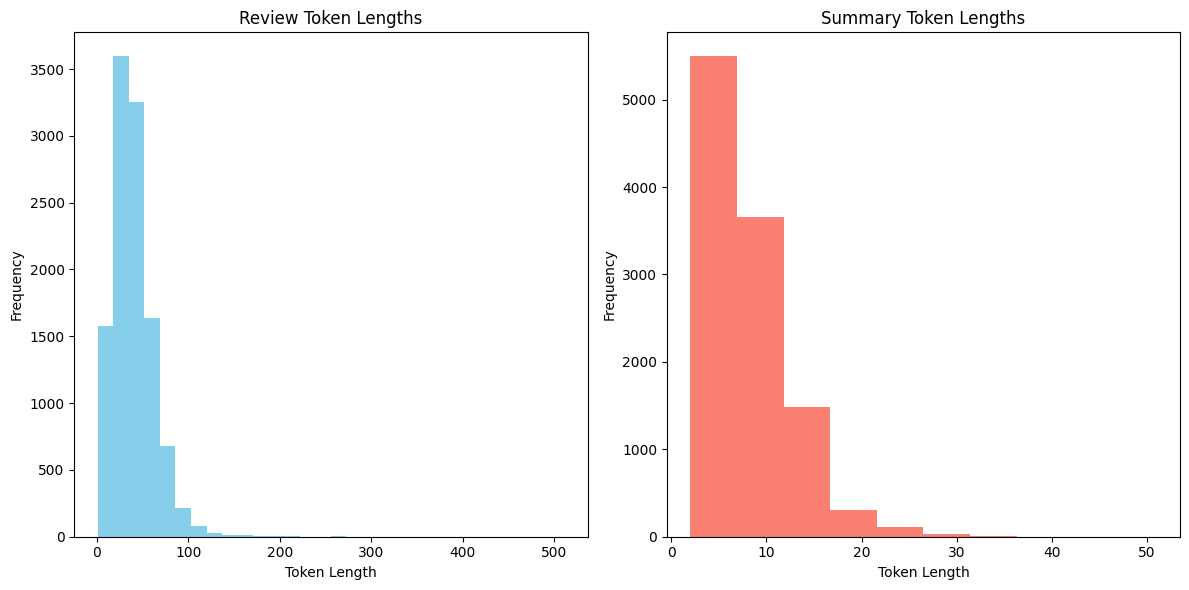

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of review token lengths
axs[0].hist(review_lengths, bins=30, color='skyblue')
axs[0].set_title('Review Token Lengths')
axs[0].set_xlabel('Token Length')
axs[0].set_ylabel('Frequency')

# Plot distribution of summary token lengths
axs[1].hist(summary_lengths, bins=10, color='salmon')
axs[1].set_title('Summary Token Lengths')
axs[1].set_xlabel('Token Length')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 2. Custom Dataset

In [ ]:
class SummarizationDataset(Dataset):
    def __init__(self, input_ids, target_ids):
        self.input_ids = input_ids
        self.target_ids = target_ids

    def __len__(self):
        return len(self.input_ids['input_ids'])

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids['input_ids'][idx],
            'attention_mask': self.input_ids['attention_mask'][idx],
            'labels': self.target_ids['input_ids'][idx],
        }

Since most reviews are under 128 tokens, we will set that as our maximum review length and truncate the rest of the review. Since most of the summary lengths are under 16 tokens, we will set the maximum review length to be 16

In [ ]:
MAX_INPUT_LEN = 256
MAX_OUTPUT_LEN = 32

In [ ]:
def make_summarization_dataset(df, input_key = 'stage1Res', target_key = 'summary'):
  input_ids = pegasus_tokenizer(df[input_key].tolist(), return_tensors='pt', max_length=MAX_INPUT_LEN, truncation=True, padding=True)
  target_ids = pegasus_tokenizer(df[target_key].tolist(), return_tensors='pt', max_length=MAX_OUTPUT_LEN, truncation=True, padding=True)
  return SummarizationDataset(input_ids, target_ids)

In [ ]:
train_dataset = make_summarization_dataset(train_df)
eval_dataset = make_summarization_dataset(dev_df)
test_dataset = make_summarization_dataset(test_df)

In [ ]:
print(len(train_dataset))
print(len(eval_dataset))
print(len(test_dataset))

11095
1387
1388


## 3. Model Training

In [ ]:
def model_init(trial):
    return PegasusForConditionalGeneration.from_pretrained(pegasus_model_name)

### Hyperparameter Tuning

In [ ]:
def objective(trial):
    return {
        "learning_rate": trial.suggest_categorical("learning_rate",[1e-5, 1e-4]),
        "per_device_train_batch_size": trial.suggest_categorical("gradient_accumulation_steps", [2, 4, 8]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-3, 1e-1, log=True),
    }

In [ ]:
trainer_args = TrainingArguments(
    evaluation_strategy='epoch',
    logging_strategy="epoch",
    output_dir='pegasus-training',
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    num_train_epochs=2
)

In [ ]:
trainer = Trainer(model=None,
                  args=trainer_args,
                  tokenizer=pegasus_tokenizer,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  model_init=model_init)

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [ ]:
# best_trial = trainer.hyperparameter_search(
#     direction="minimize",
#     backend="optuna",
#     hp_space=objective,
#     n_trials=5
# )

In [ ]:
# best_trial

### Train Second Stage

In [ ]:
BATCH_SIZE = 16
GRADIENT_ACCUMULATION_STEPS = 8
EPOCHS = 2
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.03

In [ ]:
trainer_args = TrainingArguments(
    evaluation_strategy='epoch',
    logging_strategy="epoch",
    output_dir='pegasus-training',
    optim='adafactor',
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    load_best_model_at_end=True,
    save_strategy = "epoch",
)


In [ ]:
trainer = Trainer(model=None,
                  args=trainer_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  model_init=model_init)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()
trainer.save_model('./pegasus_model')

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,7.857600,3.964759
1,3.118100,1.230957


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


## 4. Summary Generation and Evaluation

In [ ]:
model = PegasusForConditionalGeneration.from_pretrained('/content/pegasus_model')
model = model.to(device)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
dev_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
NUM_BEAMS = 8
LENGTH_PENALTY = 0.8 # discourages long summaries
def generate_summary(model, dataloader):
  summaries = []
  for batch in tqdm(dataloader):
    input_ids = batch['input_ids']
    attention_masks = batch['attention_mask']
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)

    encoded_summaries = model.generate(
          input_ids=input_ids,
          attention_mask=attention_masks,
          max_length=MAX_OUTPUT_LEN,
          num_beams=NUM_BEAMS,
          length_penalty=LENGTH_PENALTY,
          early_stopping=True
      )
    decoded_summaries = pegasus_tokenizer.batch_decode(encoded_summaries, skip_special_tokens=True)
    summaries.extend(decoded_summaries)
  return summaries

In [ ]:
train_predictions = generate_summary(model, train_loader)
dev_predictions = generate_summary(model, dev_loader)
test_predictions = generate_summary(model, test_loader)

  0%|          | 0/694 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

In [ ]:
train_references = train_df['summary']
dev_references = dev_df['summary']
test_references = test_df['summary']

In [ ]:
for i in range(len(train_predictions)):
  print("Review: " + train_df.iloc[i]['reviewText'])
  print("Stage 1 summary: " + train_df.iloc[i]['stage1Res'])
  print("Generated summary: " + train_predictions[i])
  print("Actual Summary:" + train_df.iloc[i]['summary'])
  print("\n")

Streaming output truncated to the last 5000 lines.


Review: Not great, but good.  We got this at 6-months for our son and although he could bang it didn't make sound for him because his touch was so light. It became a hit at 14-months. Watch out! Toddlers who can throw may do some damage with this one. My 16-month old hurled it across the family room. Heads up!
Stage 1 summary: Not great, but good.   It became a hit at 14-months. My 16-month old hurled it across the family room.
Generated summary: Not great, but good
Actual Summary:Good Addition to Other Leap Toys


Review: Good pairing with the Dot Marker coloring books.  Enjoy it. It is nice having so many colors to choose from.
Stage 1 summary: Good pairing with the Dot Marker coloring books.   It is nice having so many colors to choose from.
Generated summary: Good pairing with the Dot Marker coloring books
Actual Summary:A great addition


Review: We followed the directions exactly but the ladybugs never grew. They remained a tin

In [ ]:
def rouge_score(prediction, ground_truth):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(prediction, ground_truth)
    return scores

def evaluate(predictions, ground_truths):
  rouge1_f = 0
  rouge2_f = 0
  rougeL_f = 0

  num_reviews = len(predictions)
  for pred, actual in zip(predictions, ground_truths):
    scores = rouge_score(pred, actual)
    rouge1_f += scores['rouge1'][2]
    rouge2_f += scores['rouge2'][2]
    rougeL_f += scores['rougeL'][2]

  rouge1_f = rouge1_f / num_reviews
  rouge2_f = rouge2_f / num_reviews
  rougeL_f = rougeL_f / num_reviews

  return (rouge1_f, rouge2_f, rougeL_f)

In [ ]:
print("Training Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate(train_predictions, train_references)
print("ROUGE-1 F-Score: ", (rouge1_f))
print("ROUGE-2 F-Score: ", (rouge2_f))
print("ROUGE-L F-Score: ", (rougeL_f))
print("-------------")
print("Dev Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate(dev_predictions, dev_references)
print("ROUGE-1 F-Score: ", (rouge1_f))
print("ROUGE-2 F-Score: ", (rouge2_f))
print("ROUGE-L F-Score: ", (rougeL_f))
print("-------------")
print("Test Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate(test_predictions, test_references)
print("ROUGE-1 F-Score: ", (rouge1_f))
print("ROUGE-2 F-Score: ", (rouge2_f))
print("ROUGE-L F-Score: ", (rougeL_f))

Training Eval
ROUGE-1 F-Score:  0.17894148324002096
ROUGE-2 F-Score:  0.09476328144222398
ROUGE-L F-Score:  0.17331213207884286
-------------
Dev Eval
ROUGE-1 F-Score:  0.18410533574714766
ROUGE-2 F-Score:  0.09587148551639685
ROUGE-L F-Score:  0.1792269233443813
-------------
Test Eval
ROUGE-1 F-Score:  0.17790267205906726
ROUGE-2 F-Score:  0.09511078510935801
ROUGE-L F-Score:  0.17249609018444612


### Bert Score

In [ ]:
bertscore = load("bertscore")
def evaluate_bert(predictions, references):
  results = bertscore.compute(predictions=predictions,
                              references=references,
                              rescale_with_baseline=True,
                              lang='en')
  f1_scores = results['f1']
  if len(f1_scores) == 0:
    return None

  return sum(f1_scores) / len(f1_scores)

In [ ]:
print("Training Bert-Score: ", evaluate_bert(train_predictions, train_references))
print("Dev Bert-Score: ", evaluate_bert(dev_predictions, dev_references))
print("Test Bert-Score: ", evaluate_bert(test_predictions, test_references))

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Bert-Score:  0.15067624433345472
Dev Bert-Score:  0.14793917047261354
Test Bert-Score:  0.15176962137870667


### Write our results to a file

In [ ]:
def write_to_file(data, file_name):
    with open(file_name, 'w') as txtfile:
        for row in data:
            txtfile.write(str(row) + '\n')

In [ ]:
write_to_file(train_predictions, '2stage_train_pred.txt')
write_to_file(train_references, '2stage_train_ref.txt')

In [ ]:
write_to_file(dev_predictions, '2stage_dev_pred.txt')
write_to_file(dev_references, '2stage_dev_ref.txt')

In [ ]:
write_to_file(test_predictions, '2stage_test_pred.txt')
write_to_file(test_references, '2stage_test_ref.txt')

# Experimentation

Calculate performance over top k sentences provided to stage 2

In [ ]:
rouge1_f_scores = []
rouge2_f_scores = []
rougeL_f_scores = []

In [ ]:
top_k_sentences_values = [i for i in range(1,6)]

for top_k_val in top_k_sentences_values:
  torch.cuda.empty_cache()
  print(f"Training Stage 2 Model with top {top_k_val} sentences")
  # Create new training stage 1 summaries based on top k sentences
  k = top_k_val
  train_df['stage1Res'] = train_df['reviewText'].apply(create_extractive_summary, top_k = k)
  # Define new Pegasus Model
  pegasus_model = PegasusForConditionalGeneration.from_pretrained(pegasus_model_name)
  pegasus_model.to(device)
  # Train the model
  # Make new training data set
  train_dataset = make_summarization_dataset(train_df)
  # Re-define train dataloader
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
  # Define new Pegasus Model
  pegasus_model.train()
  # Train the Model
  trainer = Trainer(model=pegasus_model,
                  args=trainer_args,
                  tokenizer=pegasus_tokenizer,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset
                    )
  trainer.train()
  trainer.save_model(f'./pegasus_model_{k}')
  # Recalculate predictions
  dev_predictions = generate_summary(pegasus_model, dev_loader)
  rouge1_f, rouge2_f, rougeL_f = evaluate(dev_predictions, dev_references)
  rouge1_f_scores.append(rouge1_f)
  rouge2_f_scores.append(rouge2_f)
  rougeL_f_scores.append(rougeL_f)
  print("Rouges Scores")
  print("ROUGE-1 F-Scores: ", (rouge1_f_scores))
  print("ROUGE-2 F-Scores: ", (rouge2_f_scores))
  print("ROUGE-L F-Scores: ", (rougeL_f_scores))

In [ ]:

print("Rouges Scores")
print("ROUGE-1 F-Scores: ", (rouge1_f_scores))
print("ROUGE-2 F-Scores: ", (rouge2_f_scores))
print("ROUGE-L F-Scores: ", (rougeL_f_scores))

Rouges Scores
ROUGE-1 F-Scores:  [0.1560514977635333, 0.1724680334705034, 0.17900031178649486, 0.17487146862772956, 0.17346126852521432]
ROUGE-2 F-Scores:  [0.07407842872434506, 0.0875237818688058, 0.0952760225761944, 0.09008862979506362, 0.08635259747753517]
ROUGE-L F-Scores:  [0.14907365404293732, 0.1669291808348641, 0.1733995897872991, 0.16928549092878364, 0.16860886895440844]


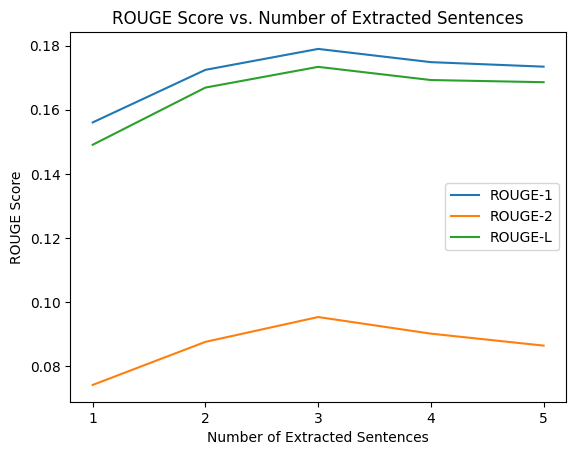

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
k_vals = [i for i in range(1,6)]
# Plot the three lines
plt.plot(k_vals, rouge1_f_scores, label='ROUGE-1')
plt.plot(k_vals, rouge2_f_scores, label='ROUGE-2')
plt.plot(k_vals, rougeL_f_scores, label='ROUGE-L')

# Add labels and a legend
plt.xlabel('Number of Extracted Sentences')
plt.ylabel('ROUGE Score')
plt.title('ROUGE Score vs. Number of Extracted Sentences')
plt.legend()
plt.xticks(k_vals)
# Show the plot
plt.show()
